The dataset for this homework is downloadable as a zip file here (Links to an external site.). In order to download the data into Colab and unzip it, please copy the following code into you first colab cell: 

# Download and unzip data
!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl

!unzip COVID-19_Radiography_Database.zip

Your final report should be written up in a Jupyter notebook.  It should be posted to a public Github repo as an ipynb AND it should be saved as an html file and submitted to this assignment via courseworks.  Please include the link to your Github repo in this html file.

# Your report should include the following information:

#### 1. Citation of paper providing original dataset:  M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145 (Links to an external site.).
#### 2. Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to.).
#### 3. Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.
#### 4. Run at least three prediction models to try to predict x-ray images well.
  - Use transfer learning for at least one of these models
  - Discuss which models performed better and point out relevant hyper-parameter values for successful models.

#### 5.Submit your best model to the leader board for the Covid X-ray Diagnostic AI Model Share competition.
#### 6. Import the best model from the leader board (whatever the best model is after your final submission)
  - Note: Use the aimodelshare instantiate_model() function
  - Visualize the model's structure using tf.kera's model.summary() 
  - Explain how the model's structure is different from your best model.
  - Explain how the model's optimization approach is different from your best model

#### 7. Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

In [1]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3




In [6]:
# Importing images from zip file and saving them to folder

!gdown --id 1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl

!unzip COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1xt7g5LkZuX09e1a8rK9sRXIrGFN6rjzl
To: /content/COVID-19_Radiography_Database.zip
1.22GB [00:18, 67.9MB/s]
Archive:  COVID-19_Radiography_Database.zip
replace COVID-19 Radiography Database/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID-19 Radiography Database/COVID.metadata.xlsx  
  inflating: COVID-19 Radiography Database/COVID/COVID (1).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (10).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (100).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1000).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1001).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1002).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1003).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1004).png  
  inflating: COVID-19 Radiography Database/COVID/COVID (1005).png  
  inflating: COVID-19 Radiog

In [7]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']
# load file names to fnames list object
fnames = []
for category in categories:
    COVID_Database = os.path.join(base_path, category)
    file_names = os.listdir(COVID_Database)
    full_path = [os.path.join( COVID_Database, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (165).png', 'COVID-19 Radiography Database/COVID/COVID (577).png', 'COVID-19 Radiography Database/COVID/COVID (1067).png', 'COVID-19 Radiography Database/COVID/COVID (840).png', 'COVID-19 Radiography Database/COVID/COVID (879).png', 'COVID-19 Radiography Database/COVID/COVID (692).png', 'COVID-19 Radiography Database/COVID/COVID (919).png', 'COVID-19 Radiography Database/COVID/COVID (487).png', 'COVID-19 Radiography Database/COVID/COVID (761).png', 'COVID-19 Radiography Database/COVID/COVID (378).png', 'COVID-19 Radiography Database/COVID/COVID (679).png', 'COVID-19 Radiography Database/COVID/COVID (119).png', 'COVID-19 Radiography Database/COVID/COVID (842).png', 'COVID-19 Radiography Database/COVID/COVID (1173).png', 'COVID-19 Radiography Database/COVID/COVID (926).png', 'COVID-19 Radiography Database/COVID/COVID (353).png', 'COVID-19 Radiography Database/COVID/COVID (1021).png', 'COVI

In [8]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (192,192)) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19 Radiography Database/COVID/COVID (165).png').shape

(192, 192, 3)

In [11]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
COVID_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,COVID_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [12]:
X.shape

(3886, 192, 192, 3)

In [13]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
COVID =list(repeat("COVID", 1200))
NORMAL =list(repeat("NORMAL", 1341))
Viral_Pneumonia=list(repeat("Viral Pneumonia", 1345))

#combine into single list of y labels
y_labels = COVID+NORMAL+Viral_Pneumonia
#check length, same as X above
len(y_labels) 

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)
X[0].shape

number of images for each category: [1200, 1341, 1345]


,COVID,NORMAL,Viral Pneumonia
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


(192, 192, 3)

#### 2. Visualize images that demonstrate when x-rays demonstrate Covid Postivity and when they do not (You can present visuals of each category in the data if you would like to.).


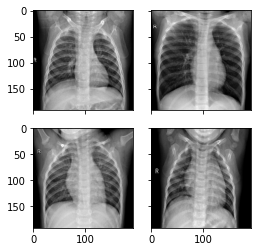

In [ ]:
# X-Ray images demonstrating normal lungs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

imN1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (856).png')
imN2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (857).png')
imN3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (858).png')
imN4 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (89).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [imN1, imN2, imN3, imN4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()
 

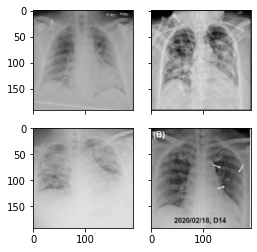

In [ ]:
# X-Ray images demonstrating COVID-19 Positive lungs

imP1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (812).png')
imP2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (856).png')
imP3 =preprocessor('COVID-19 Radiography Database/COVID/COVID (79).png')
imP4 =preprocessor('COVID-19 Radiography Database/COVID/COVID (60).png')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [imP1, imP2, imP3, imP4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()


#### 3. Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; State-of-the-art image processing techniques are being widely used in the diagnosis of diseases by processing medical images such as X-rays, MRIs, and others. Compared to more traditional techniques that are more expensive, less accurate and requires special medical personnel, training computers to diagnose diseases or facilitate surgeries becomes a more popular choice becasue of it's versatility and efficiency. 
       
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; These comparative advanges of computer vision techniques become espicially evident at the disastrous shock of the Coronavirus pandemic disease which put the hospital system, human resilience, and our ability to quickly adapt technology to test. Prompt response to the pandemic requires state-of-the-art computer vision technologies and applying it to the early diagnose and treatment of the disease, among others. Therefore, building models that could accurately predict COVID-19 infection and gathering datas to train these models become the primary tasks of researchers. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The dataset is a collection of chest X-ray images from six different databases. The COVID-19 databse is collected by the author from publicly avaible databases, whie normal and viral pneumonia databases are collected from publicly avaible Kaggle databases. Details of each database is summarized in the original paper.  

#### 4. Run at least three prediction models to try to predict x-ray images well.
  - Use transfer learning for at least one of these models
  - Discuss which models performed better and point out relevant hyper-parameter values for successful models.


In [14]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)

for i in [X_train, X_test, y_train, y_test]:
  print(i.shape)

y_train

(3108, 192, 192, 3)
(778, 192, 192, 3)
(3108, 3)
(778, 3)


,COVID,NORMAL,Viral Pneumonia
3256,0,0,1
1265,0,1,0
1188,1,0,0
118,1,0,0
3215,0,0,1
...,...,...,...
122,1,0,0
3540,0,0,1
443,1,0,0
247,1,0,0


#### First Model: Squeezenet Model

In [40]:
# Let's build a squeezenet model instead to see how well it performs 
# Does adding more layers help (i.e.- try building a deeper and deeper network)

l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = Dropout(rate=0.5)(y) #add dropout layer to prevent overfitting
            y = fire_module(24, 68)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = Dropout(rate = 0.5)(y)
            y = fire_module(24, 88)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(3, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)
        
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
        
            model.fit(X_train, y_train, 
                    epochs = 4, verbose=1,validation_data=(X_test,y_test))

Train on 3108 samples, validate on 778 samples
Epoch 1/4
3108/3108 [==============================] - 444s 143ms/sample - loss: 1.0511 - acc: 0.4157 - val_loss: 0.9491 - val_acc: 0.5617
Epoch 2/4
3108/3108 [==============================] - 440s 142ms/sample - loss: 0.9177 - acc: 0.5479 - val_loss: 0.8554 - val_acc: 0.6067
Epoch 3/4
3108/3108 [==============================] - 437s 141ms/sample - loss: 0.8693 - acc: 0.5952 - val_loss: 0.8481 - val_acc: 0.5900
Epoch 4/4
3108/3108 [==============================] - 437s 141ms/sample - loss: 0.7604 - acc: 0.6612 - val_loss: 0.7377 - val_acc: 0.6427


#### Second Model: VGG16 Model

In [ ]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

base_model2 = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition

base_model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [ ]:

# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model2.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
# define new model
model2 = Model(inputs=base_model2.inputs, outputs=output) #base_model.inputs imports the vgg16 model defined in base_model
  
# summarize
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0   

In [ ]:
# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model2.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model2.fit(X_train, y_train,batch_size=2,
          epochs = 2, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])


Epoch 1/2
1554/1554 [==============================] - ETA: 0s - loss: nan - acc: 0.3139

KeyboardInterrupt: ignored

#### Third Model:  Resnet Model with Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# Create the base model from the pre-trained model VGG16
base_modelr = ResNet50(input_shape=(192, 192, 3), include_top=False, weights='imagenet')

base_modelr.summary() # Notice unfrozen number of trainable parameters

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
__________________________

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_modelr.trainable = False

base_modelr.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input


# Getting output tensor of the last VGG layer that we want to include
# base_model.layers[-1].output sets input for next model layer

# example of tending the vgg16 model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_modelr.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model3 = Model(inputs=base_modelr.inputs, outputs=output)
# summarize
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 96, 96, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Fit Resnet model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model3.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))


Epoch 1/5
98/98 [==============================] - 406s 4s/step - loss: 1.3926 - acc: 0.3820 - val_loss: 1.5344 - val_acc: 0.3458
Epoch 2/5
98/98 [==============================] - 410s 4s/step - loss: 1.3660 - acc: 0.3921 - val_loss: 1.1491 - val_acc: 0.3111
Epoch 3/5
98/98 [==============================] - 412s 4s/step - loss: 1.3119 - acc: 0.4117 - val_loss: 3.4942 - val_acc: 0.3458
Epoch 4/5
98/98 [==============================] - 415s 4s/step - loss: 1.2812 - acc: 0.4553 - val_loss: 4.0452 - val_acc: 0.3085
Epoch 5/5
98/98 [==============================] - 413s 4s/step - loss: 1.2493 - acc: 0.4779 - val_loss: 1.8581 - val_acc: 0.3458


**EVALUATION:** Overall, our first model, Squeezenet, has the best performance among the other models. The nypterparameter, epoch, is set to four, which means the model runs through the entire training dataset four times. To avoid overfitting on the trainning dataset, I also added two dropout of 0.5 layers to the model. The dropout layer will randomly switch off 50% of the neurons and reduce model complexity. Our third model has a significantly higher accuracy score than the validation accuracy score, which means the model is overfitting on the training dataset. 

Although we have seen an improvement from 0.3 to 0.66 in the accuracy score after adding the drop out layers, this improvement is not shown on the leaderboard. 


#### 5.Submit your best model to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [15]:
# test with aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
Requirement already up-to-date: aimodelshare in /usr/local/lib/python3.7/dist-packages (0.0.61)


In [42]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

# Extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata


[2 2 0 2 2 0 2 0 2 2 2 2 0 2 0 2 0 2 2 0 2 2 2 0 2 2 2 1 2 2 1 0 2 1 2 0 2
 2 0 2 2 0 2 0 1 1 2 0 2 2 0 1 2 2 2 1 2 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 0 2
 2 2 1 2 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 0 2 2 0 2 0 0 2 0 2 0 2 0 0 0
 0 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 1 1 0 0 2 1 2 0 0 1 2 2 2 1 0 0
 2 2 2 2 2 2 2 2 0 0 2 1 2 2 2 0 2 2 2 0 0 0 2 2 2 2 0 0 0 2 0 2 2 2 2 2 2
 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 0 2 0 2 0 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0
 2 2 2 0 2 2 2 1 2 2 0 2 2 2 2 2 0 2 2 0 0 2 2 0 2 0 2 1 0 2 2 0 2 2 2 0 2
 0 2 0 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 0 0 2 0 0 0 2 0 2 2 2 0 2 2 2
 2 0 2 0 0 2 2 2 2 2 0 0 2 2 2 1 1 2 2 0 2 2 0 2 2 2 2 0 2 2 2 2 2 2 0 2 2
 2 0 0 2 2 2 2 2 0 0 2 0 2 0 2 2 2 0 2 2 0 2 0 2 2 1 0 0 2 2 0 2 0 0 2 2 0
 0 2 2 2 2 2 2 2 2 0 2 2 1 2 0 1 1 2 0 0 2 0 2 2 2 2 2 0 0 2 2 2 0 2 0 0 2
 2 2 2 2 0 2 0 0 2 2 0 2 0 0 0 0 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 0 1 2 2 2 2 1 2 0 2 2 1 2 2 2 2 2 2 2 2 0 0 2 0 2 0 1 2 0 0 2 1 2 2
 2 2 2 2 2 0 2 0 2 2 0 2 

In [43]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test.idxmax(axis=1) #returns a pandas series of predicted labels


3235    Viral Pneumonia
2083             NORMAL
1041              COVID
1781             NORMAL
3070    Viral Pneumonia
             ...       
3139    Viral Pneumonia
3426    Viral Pneumonia
1846             NORMAL
811               COVID
3220    Viral Pneumonia
Length: 778, dtype: object

In [56]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.642674,0.601103,0.743109,0.650423,0,0,0,0


In [41]:
pip install delayed

In [48]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") #ignore error "can't pickle module objects"

In [42]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [49]:

from aimodelshare.aimsonnx import model_to_onnx
# transform sklearn model to ONNX
onnx_model_keras= model_to_onnx(model, framework='keras', 
                                   transfer_learning=False,
                                   deep_learning=True,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_keras.onnx", "wb") as f:
    f.write(onnx_model_keras.SerializeToString())

The ONNX operator number change on the optimization: 65 -> 32


In [50]:
# Set credentials to submit new model/preprocessor
from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="submit_model", apiurl="") 


AI Model Share login credentials set successfully.
AWS credentials set successfully.


In [51]:
import aimodelshare as ai
import os
token=ai.aws.get_aws_token(os.environ.get("username"), os.environ.get("password"))
awscreds=ai.aws.get_aws_client(aws_key=os.environ.get('AWS_ACCESS_KEY_ID'), aws_secret=os.environ.get('AWS_SECRET_ACCESS_KEY'), aws_region=os.environ.get('AWS_REGION'))

In [57]:
# Submit_model() to leaderboard
ai.submit_model("onnx_model_keras.onnx",
                "https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predicted_labels,
                preprocessor="preprocessor.zip")

'Your model has been submitted as model version 58'

In [58]:
import pandas
data=ai.get_leaderboard("https://sxr89y55o4.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,verbose=1)

#get rid of any duplicate model submissions
data=data.loc[data.iloc[:,0:8].duplicated()==False,:]
data.fillna(0,inplace=True)
data.loc[data["username"] == "xuejingli"]

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,loss,optimizer,model_config,username,timestamp,version
38,0.318766,0.287403,0.431834,0.253617,keras,False,True,Model,20,29471,str,Adam,"{'name': 'model_1', 'layers': [{'name': 'input...",xuejingli,2021-03-08 18:53:19.328896,58
41,0.300771,0.228051,0.447735,0.242964,keras,False,True,Model,18,21611,str,Adam,"{'name': 'model', 'layers': [{'name': 'input_1...",xuejingli,2021-03-08 17:57:18.211171,54
42,0.300771,0.228051,0.447735,0.242964,keras,True,True,Model,18,21611,str,Adam,"{'name': 'model', 'layers': [{'name': 'input_1...",xuejingli,2021-03-08 17:56:52.683858,53


### GithubRepo: https://github.com/GraceXuejingLi/MLProject2021/tree/main/%232%20ImageData

In [2]:
pip install nbconvert

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nbformat

Note: you may need to restart the kernel to use updated packages.
